# Clustering Algorithms

The commonly used clustering algorithms can be divided in 4 categories:
- Centroid-based.
- Hierarchical.
- Distribution-based.
- Density-based.

In this lecture, we're gonna get into the elementary concepts of each category, and we're gonna create a clustering model using such knowledge.

### Clustering as a classic ML problem

First, a brief introduction:
Clustering is a canonical ML problem, is part of the reign of Unsupervised Learning because it is *not* used to classify any outcome, but to learn the hidden structure within the data in order to find structure or patterns.

#### K-means Clustering

- Pick an initial solution (algoritgms exist to pick well)
    - Set the hyperparameters
        - Number of clusters
        - Initial values of centroids
- Iterate until convergence
    - Update assignments of points to clusters
        - Distance measure between point, cluster
            - Euclidean distance often used
    - Update coordinates of recerence vectors (**centroids**)
        - Calculating cluster center from points in cluster
            - Centroid (simple average) often used
- Keep iterating until convergence

## Evaluating Clustering Models

### Homogeinity

- Each cluster should contain members of the same class

### Completeness

- All members of a class should lie in the same cluser

>Homogeinity and Completeness are inversely related
<br>Each lies between 0 and 1
<br>Similar to precision and recall
<br>Need a metric to optimize trade-off

### V-measure

- Harmonic mean of Homogeinity and Completeness
- Closer to lower of two
- Favors even weightage to both metrics

>Related set of metrics
<br>Bounded scores between 0 and 1
<br>Easy to interpret - higher is better
<br>Apply to any algorithm
<br>However, require **labeled data**

There are other metrics to evaluate the clustering models, but for now we'll stay at this point.

# Exploring and Performing K-means Clustering in the Iris Dataset

In [1]:
# First we import the libraries that we're gonna use in this exercise
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Make sure you also import the K-means estimator object and ignore the warnings
from sklearn import metrics
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Now, let's read the iris dataset and convert it into a dataframe
from sklearn.datasets import load_iris
iris = load_iris()
#iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
#iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['class'])
iris_df= pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0.0,setosa
1,4.9,3.0,1.4,0.2,0.0,setosa
2,4.7,3.2,1.3,0.2,0.0,setosa
3,4.6,3.1,1.5,0.2,0.0,setosa
4,5.0,3.6,1.4,0.2,0.0,setosa


In [4]:
# Let's resample the df to have a more aleatory index order
iris_df = iris_df.drop('target', axis=1)
iris_df = iris_df.sample(frac=1).reset_index(drop=True)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,6.7,3.3,5.7,2.1,virginica
1,5.5,3.5,1.3,0.2,setosa
2,6.0,2.9,4.5,1.5,versicolor
3,5.8,4.0,1.2,0.2,setosa
4,6.5,3.0,5.2,2.0,virginica


In [5]:
iris_df.shape

(150, 5)

In [6]:
# Let's see the unique labels in the df
iris_df['species'].unique() 

['virginica', 'setosa', 'versicolor']
Categories (3, object): ['setosa', 'versicolor', 'virginica']

Remember, the algorithm only works with numerical data, so we have to encode the categorical variables to proceed

In [7]:
from sklearn import preprocessing
label_encoding = preprocessing.LabelEncoder()

iris_df['species'] = label_encoding.fit_transform(iris_df['species'].astype(str))
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,6.7,3.3,5.7,2.1,2
1,5.5,3.5,1.3,0.2,0
2,6.0,2.9,4.5,1.5,1
3,5.8,4.0,1.2,0.2,0
4,6.5,3.0,5.2,2.0,2


Now, let's see how the data distributes in the dataframe and how the relation looks like

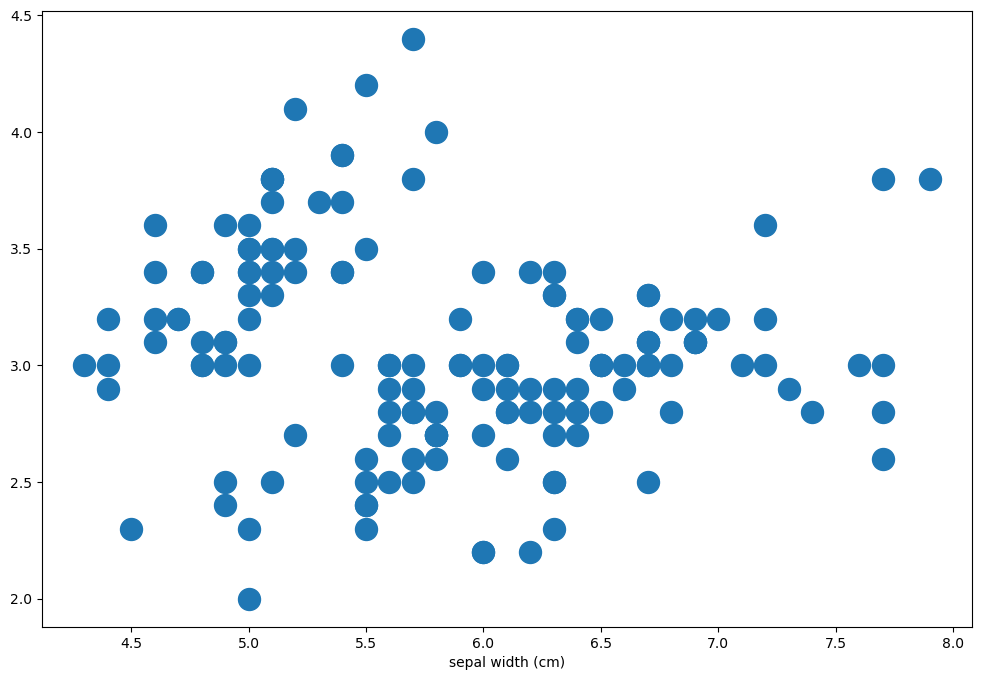

In [8]:
fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(iris_df['sepal length (cm)'], iris_df['sepal width (cm)'], s = 250)

plt.xlabel('sepal length (cm)')
plt.xlabel('sepal width (cm)')

plt.show()

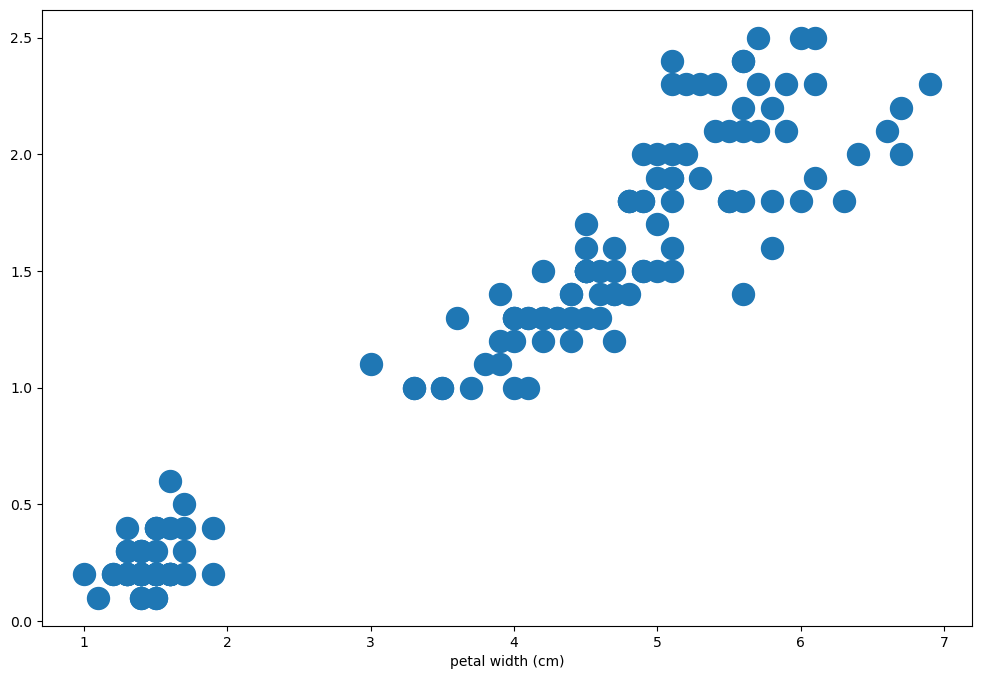

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(iris_df['petal length (cm)'], iris_df['petal width (cm)'], s = 250)

plt.xlabel('petal length (cm)')
plt.xlabel('petal width (cm)')

plt.show()

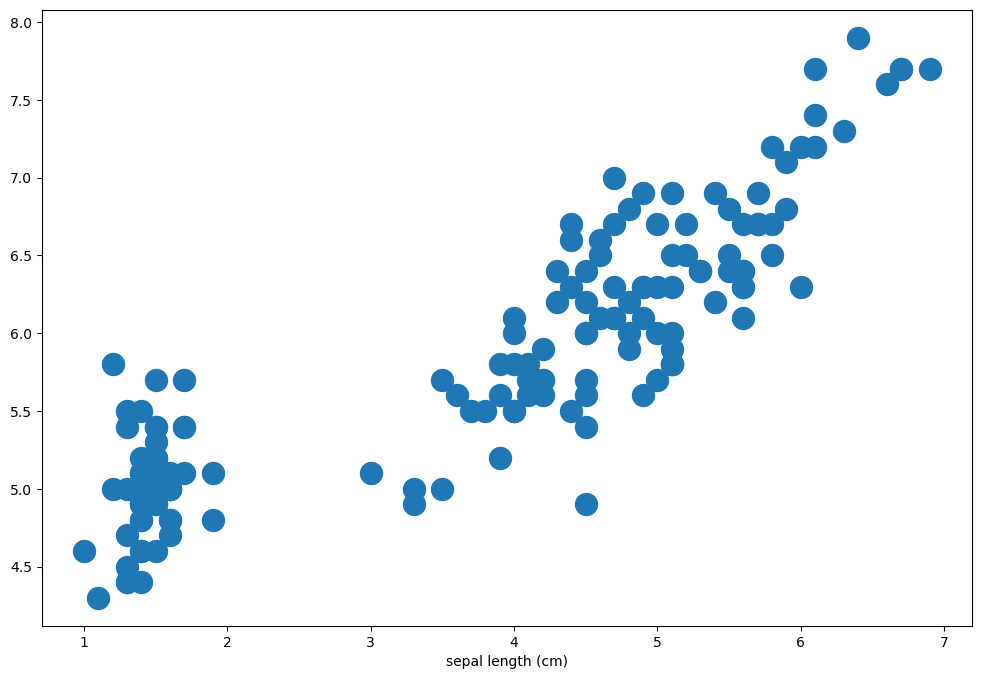

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(iris_df['petal length (cm)'], iris_df['sepal length (cm)'], s = 250)

plt.xlabel('petal length (cm)')
plt.xlabel('sepal length (cm)')

plt.show()

We proceed to define a function to apply the clustering algorithm

In [11]:
iris_features = iris_df.drop('species', axis=1)

iris_features.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.7,3.3,5.7,2.1
1,5.5,3.5,1.3,0.2
2,6.0,2.9,4.5,1.5
3,5.8,4.0,1.2,0.2
4,6.5,3.0,5.2,2.0


In [12]:
iris_labels = iris_df['species']
iris_labels.sample(5)

28     0
129    2
82     0
5      1
58     2
Name: species, dtype: int32

In [13]:
def build_model(clustering_model, data, labels):

    model = clustering_model(data)

    print('homo\tcomp\tv-meas\tARI\tAMI\tsilhouette')
    print(50 * '-')

    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          %(metrics.homogeneity_score(labels, model.labels_),
            metrics.completeness_score(labels, model.labels_),
            metrics.v_measure_score(labels, model.labels_),
            metrics.adjusted_rand_score(labels, model.labels_),
            metrics.adjusted_mutual_info_score(labels, model.labels_),
            metrics.silhouette_score(data, model.labels_)))

In [14]:
def k_means(data, n_clusters=3, max_iter=1000):
    model = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(data)

    return model

Finally, we apply the function (model) to our data

In [15]:
build_model(k_means, iris_features, iris_labels)

homo	comp	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.751	0.765	0.758	0.730	0.755	0.553


# Choosing Clustering Algorithms

As we have stated previously, there are 4 types of *Clustering Algorithmns*. Now, we're gonna expand a little more on that topic:
- **Centroid-based**
    - Cluster represented by a central reference vector which may not be a part of the original data, *e.g. K-means clustering*.
- **Hierarchical**
    - Connectivity-based clustering based on the core idea that points are connected to points close by rather than further away.
    - A cluster can be defined largely by the maximum distance needed to connect different parts of the cluster.
    - Unlike Centroid-based clusters, Hierarchical clusters do not partition the dataset, but instead construct a tree of points which are typically merged together, *e.g. Agglomerative and BIRCH clustering*.
- **Distribution-based**
    - Built on statistical distribution models - objects of a cluster are the ones which belong most likely to the same distribution. This is tipically the case of artificial generated datasets, such as random samples.
    - They tend to be complex clustering models which might be prone to overfitting on data points. Unless, the clustering parameters are constringe using some kind of regularization techiniques.
    - However, this clustering algorithms are not easy to use, e.g. *Gaussian mixture models*.
- **Density-based**
    - Create clusters from areas which have a higher density of data points.
    - Objects in sparse areas, which separate clusters, are considered noise and border points, e.g. *DBSCAN and mean-shift clustering*.

## Hierarchical Clustering

Now, we have already take a glance at *Centroid-based* algorithms in the previous example of the k-means on the iris dataset. So, let's compare it with the next type, the *Hierarchical* algorithms. 

There are two broad ways in which *Hierarchical Clustering* can be performed on data:
- Agglomerative: Start with many 1-point clusters, end with 1 big cluster that contains all the points.
- Divisive: Start with 1 big cluster, end with many 1-point clusters.

### Contrasting Clustering Algorithms

| K-Means                            | Hierarchical                       |
|                              :----:|:----:                              |
| Need distance measure as well as way to aggregate points in a cluster. | Only need distance measure; do not need way to combine points in a cluster. |
| Must represent data as vectors in N-dimensional hyperspace. | No need to express data as vectors in N-dimensional hyperspace. |
| Data representation can be difficult for complex data types. | Relatively simple to represent even complex data *e.g graphs, documents*. |
| Variants (*e.g. BFR*) can be efficiently deal woth bery large datasets on disk. | Even with careful construction too computationally expensive for large datasets on disk. |

### BIRCH Clustering

If you have a large dataset that has to be clustered into many different clusters, BIRCH is one of the algorithms that you would pick.
Some advantages over the Agglomerative clustering are that BIRCH detects and removes outliers in your data, also is very memory and time efficient, because it is not needed to upload the entire dataset into memory. Another significant feature of such algorithm is that it has the ability to incrementally process incoming data in the form of a stream and update clusters based on new incoming data. 
This makes BIRCH an online clustering (Online-learning) algorithm.

BIRCH stands for **B**alanced **I**terative **R**educing and **C**lustering using **H**ierarchies. 

In [16]:
# Make sure you import the BIRCH estimator object
import numpy as np

from sklearn import metrics
from sklearn.cluster import Birch

In [17]:
def birch_fn(data, n_clusters=3):
    model = Birch(n_clusters=n_clusters).fit(data)
    return model

In [18]:
build_model(birch_fn, iris_features, iris_labels)

homo	comp	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.635	0.792	0.705	0.566	0.700	0.534


## Density-based Clustering

### DBSCAN Clustering

DBSCAN stands for: **D**ensity-**b**ased **S**patial **C**lustering of **A**pplications with **N**oise. Basically, what DbSCAN does is trying to find areas or regions that have a high density of points, as a result, we shall have density-based clustering groups together closely packed points. If there are *points* with few near neighbors, then they are marked as outliers. A written mental note: DbSCAN is not as good as BIRCH at dealing with noise and outliers.

When configuring the algorithm, there are two main parameters that needs to be considered and specified:
- eps: Minimum distance, points closer than this are **neighbors**. 
- min_samples: Minimum number of points to form a dense region.

In [19]:
# Make sure you import the DBSCAN estimator object
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

In [20]:
def dbscan_fn(data, eps=0.45, min_samples=4):
    model = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    return model

In [21]:
build_model(dbscan_fn, iris_features, iris_labels)

homo	comp	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.577	0.609	0.593	0.508	0.584	0.372


Note: DBSCAN is a special case of *Spectral Clustering*.

### Mean-shift Clustering

As the DBSCAN Clustering method, Mean-shift Clustering is also a Density-based model. In this case, for each point, we calculate a function based on all points in the neighberhood. That function is called the **kernel**. So, let's define the following for better understanding:
- **Flat kernel**: Sum of all points in the neighborhood. Note: *Each point gets the same weight, all points have the same importance*.
- **Gaussian (RBF) kernel**: Probability-weighted sum of points. This RBF or **R**adial **B**asis **F**unction kernel it is commonly used in several ML algorithms. For every point, you can apply this function to all of the neighborhood points, but, what is the probability distribution? A common choice would be:
    - **Gaussian probability distribution**: As we know, this is defined by:
        - mean $μ$
        - standard deviation $σ$

When we applied this distribution to our *Gaussian (RBF) kernel*, $μ$ = center point and $σ$ = **the bandwidth** (*Bandwidth is a parameter of the algorithm*).

So, once we set this up, let's see what does Mean shift Clustering do:
1. Applies the *Gaussian (RBF) kernel* to each one of the points in the dataset.
2. Assume points are color-coded by magnitud of *RBF*. High values of the *RBF* are *peaks*, in the other hand, low values are *troughs*.
3. Now, all points start to "shift" towards the **nearest** *peak*.
4. Then, the kernel function will be recalculated to all the new points - formerly *peaks*. This process is called the **"mean shift"**.
5. This algorithm converges when all of the points stop moving and a few *peaks* have been found: this are our clusters.

The only design parameter that need to be specified is, **the bandwidth**; the role for this value should be based on how tall or flatten you want your distribution to be. If bandwidth is short, then the points far from the mean will be ignored. If long, then the points far from the mean will be considered.




#### Comparing similarities (yet different) with K-Means

| K-Means Clustering                            | Mean Shift Clustering                       |
|                              :----:|:----:                              |
| Need to specify number of clusters as hyperparameter. | No need to specify number of clusters upfront as hyperparameter. |
| Can't handle some complex non-linear data. | Uses density funcion to handle even complex non-linear data *e.g. pixels*. |
| Less hyperparameter tuning needed. | Hyperparameter tuning very important. |
| Computationally less intensive. | Computationally very intensive. |
| More simple complexity. | Higher complexity in number of data points. |
| Struggles with outliers. | Copes better with outliers. |

In [22]:
# Make sure you import the mean-shift estimator object
import numpy as np

from sklearn import metrics
from sklearn.cluster import MeanShift

In [23]:
def mean_shift_fn(data, bandwidth=0.85):
    model = MeanShift(bandwidth=bandwidth).fit(data)
    return model

In [24]:
build_model(mean_shift_fn, iris_features, iris_labels)

homo	comp	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.760	0.772	0.766	0.744	0.763	0.551


## Mini-batch K-means Clustering

If we want a moderate number of clusters on a very large dataset, the clustering algorithms that we'll choose to use are k-means and DBCSCAN. However, if the dataset is to large and you are having trouble with the time performance of the algorithm, mini-batch k-means can be a solution.

The objective and implementation of mini-batch k-means is **exactly** the same of the original version. However, the big difference is that, in the original, we perform k-means on the entire dataset; whereas in mini-batch version we perform k-means on randomly sampled subsets of the data. These randomly sampled subsets are referred to as *mini-batches*. Allowing us to drastically reduce the computation time required to converge to a local solution.

So, it's faster but also can affect the metrics performance compared to the k-means on the whole data. Nevertheless, the *trade-off* involved is generally acceptable, it is usually only slightly worse than performing the algorithm on the entire dataset.

In [25]:
# Make sure you import the Mini-batch K-means estimator object
#import numpy as np

#from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans

In [26]:
def mini_batch_kmeans_fn(data, n_clusters=3, max_iter=1000):
    model = MiniBatchKMeans(n_clusters=n_clusters, max_iter=max_iter, batch_size=20).fit(data)
    return model

In [27]:
build_model(mini_batch_kmeans_fn, iris_features, iris_labels)

homo	comp	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.737	0.740	0.739	0.728	0.735	0.539


# Hyperparameter Tuning for Clustering Models

## Understanding the Silhouette Score

### Evaluating Clustering Models

We've seen in earlier notes all of these different techniques that you can use to **evaluate** better the clustering performed by our model was good or not.

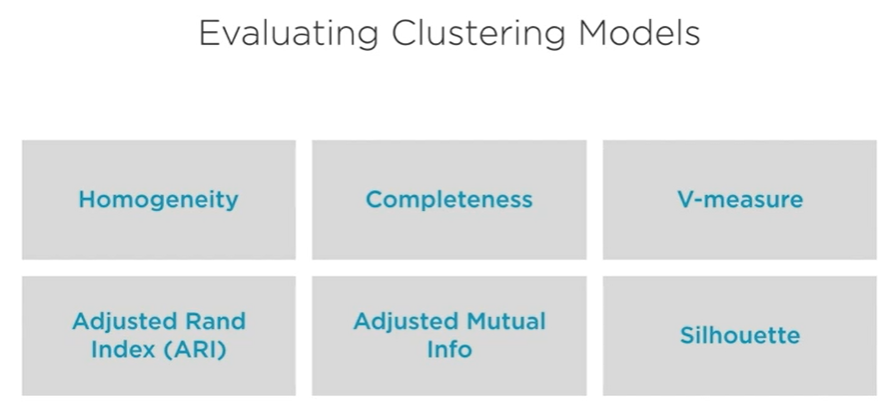

Of all of these techniques, only one, the **silhouette** coding tecnique did **not** need labeled data.

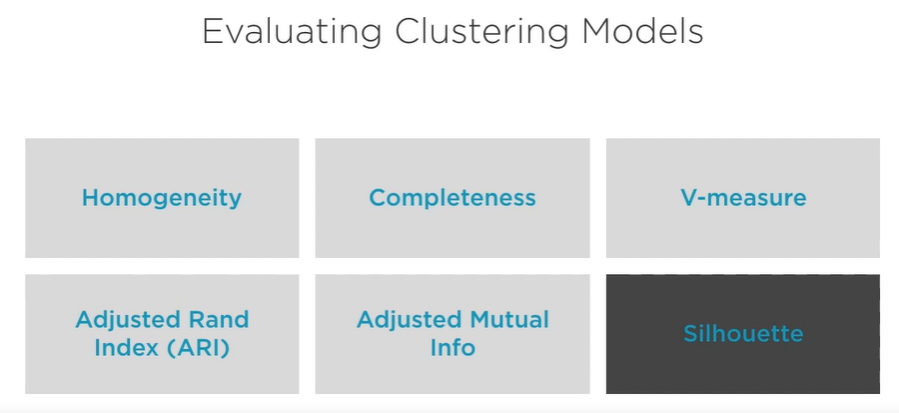

This is a great advantage, which is why we are going to use the silhouettes code to evaluate the different clustering models that we build when we perform hyperparameter tuning.

### The Silhouette Coefficient

The main points that conforms the **Silhouette Score** are:
- Defines Silhouette coefficient for each sample.
- Measure of how similar an object is to objects in its own cluster.
- And how different it is from objects in other clusters.
- Overall Silhouette score averages Silhouette coefficient of each sample.
- No need for labeled data.

The silhouette coefficient evaluates the quality of clusters formed in a clustering algorithm. It quantifies how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

For each data point `i` in cluster `C`, the silhouette coefficient $s^i$ is calculated as follows:

$s^i = \frac{b^i-a^i}{max(a^i,b^i)}$

Where:
- `a(i)` is the mean distance from point `i` to all other points in the same cluster `C` (excluding `i`).
- `b(i)` is the mean distance from point `i` to all points in next nearest cluster (i.e., the cluster with which `i` has the lowest distance).

The **overall silhouette score** is the average of all individual silhouette coefficients (for all points):

$S = \frac{1}{n} \sum_{i=1}^ns^i$

When using this *coefficient* to evaluate the performance of our clustering model, keep in mind that:
- The **Silhouette Score** is bounded between `-1` *(incorrect)* and `+1` *(perfect)*.
- Scores around `0` indicate overlapping clusters.
- Tends to be higher for dense and well separated clusters. 

## K-means Number of Clusters

### The Elbow Method

1. Pick range of candidate values of **`K`** *e.g. 1 to 10*.
2. Perform *K-means Clustering* and calculate the average distance from centroid for each values.
3. Plot and find `"elbow"`.

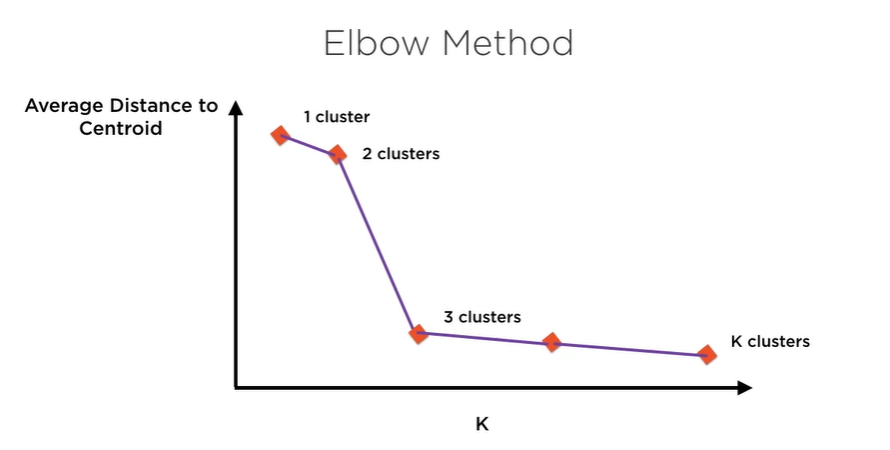

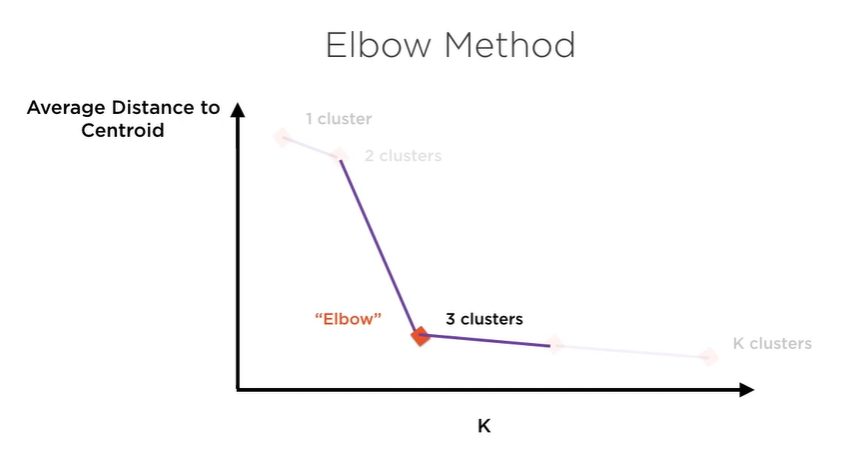

### The Silhouette Method

1. Pick range of candidates values of **`K`** *e.g. 1 to 10*.
2. Plot `silhouettes` for each value of **K**.
3. Ideal value of silhouette = 1.
4. Worst possible value of silhouette = -1.
5. Pick **K** where average `silhouette` is closest to 1.

### Seeds and Distance Measures

#### Seeds

- Final reference vector valueas sensitive to initial values.
- Random initialization might not work - examine data carefully.

#### Distance Measures

Can choose multiple distance measures:

- `Euclidean distance` - centroid might not be actual data point.
- `Mahalanobis distance` - normalize each dimension to hace equal variance.
- `Cosine distance` - cosine of angle between point and centroid.